<a href="https://colab.research.google.com/github/DanielHolzwart/Titanic-Kaggle-/blob/main/titanic_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [8]:
%cd /content/drive/MyDrive/Kaggle/Titanic

/content/drive/MyDrive/Kaggle/Titanic


In [ ]:
!kaggle competitions download -c titanic --force

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 2.06MB/s]


In [ ]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [9]:
%ls

gender_submission.csv  test.csv  titanic_nn.ipynb  train.csv


In [10]:
import numpy as np
import pandas as pd

In [11]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')
train_data.head()
test_data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [12]:
train_data = train_data.drop(["PassengerId","Name","Ticket","Cabin","Fare"], axis = 1)
test_data = test_data.drop(["PassengerId","Name","Ticket","Cabin","Fare"], axis = 1)

In [13]:
print(train_data.isna().sum())
print(test_data.isna().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Embarked     0
dtype: int64


In [15]:
#At first we will deal with the 2 NA in embarked. Simply dropping the values should be sufficient as these are only two rows
train_data = train_data.dropna(subset = 'Embarked')

In [16]:
#the numeric column are normalized by having standard diviation 1 and mean 0
train_stats = train_data.describe().transpose()
numeric_column_names = ["Age"]
train_data_norm, test_data_norm = train_data.copy(), test_data.copy()
for i in numeric_column_names:
    mean = train_stats.loc[i,'mean']
    std = train_stats.loc[i,'std']
    train_data_norm[i] = (train_data_norm[i] -  mean) / std
    test_data_norm[i] = (test_data_norm[i] - mean)/std
train_data_norm.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
886,0,2,male,-0.182302,0,0,S
887,1,1,female,-0.734295,0,0,S
888,0,3,female,NaN,1,2,S
889,1,1,male,-0.251301,0,0,C
890,0,3,male,0.162694,0,0,Q


In [17]:
#Now we deal with the missing ages. A sensible approach is to take the mean of all ages. Since we have normalized the data already, we set it to 0
train_data_norm.fillna({"Age" : 0}, inplace = True)
test_data_norm.fillna({"Age" : 0}, inplace = True)

In [18]:
#Now let us have a look at the categorical column names: Sex and Embarked. Embarked should not be important for the data but we will consider it anyway for the gigs of it. This is done via one-hot encoding
cat_column_names = ["Sex", "Embarked"]
for i in cat_column_names:
    unis = train_data_norm[i].unique()
    k=0
    for j in unis:
        train_data_norm.replace({j : k}, inplace = True)
        test_data_norm.replace({j : k}, inplace = True)
        k += 1

In [19]:
#Starting from here we perpare data for the NN.

import torch
from torch.nn.functional import one_hot
#train set
total_origin = len(set(train_data_norm["Sex"]))
origin_encoded_sex = one_hot(torch.from_numpy(train_data_norm["Sex"].values) % total_origin)
total_origin = len(set(train_data_norm["Embarked"]))
origin_encoded_embarked = one_hot(torch.from_numpy(train_data_norm["Embarked"].values) % total_origin)
origin_encoded_train = torch.cat([origin_encoded_sex,origin_encoded_embarked], dim= 1)

In [20]:
#test set
total_origin = len(set(test_data_norm["Sex"]))
origin_encoded_sex = one_hot(torch.from_numpy(test_data_norm["Sex"].values) % total_origin)
total_origin = len(set(test_data_norm["Embarked"]))
origin_encoded_embarked = one_hot(torch.from_numpy(test_data_norm["Embarked"].values) % total_origin)
origin_encoded_test = torch.cat([origin_encoded_sex,origin_encoded_embarked], dim= 1)

In [21]:
#finding out the reamining column names
remaining_columns = train_data_norm.columns.difference(train_data_norm[numeric_column_names].columns)
remaining_columns = remaining_columns.difference(train_data_norm[cat_column_names].columns)
remaining_columns

Index(['Parch', 'Pclass', 'SibSp', 'Survived'], dtype='object')

In [23]:
#split the train and test data into numerical, categorical and remaining column names
x_train_numeric = torch.tensor(train_data_norm[numeric_column_names].values)
x_train_remainig = torch.tensor(train_data_norm[remaining_columns].values)
x_train = torch.cat([x_train_numeric, x_train_remainig, origin_encoded_train], 1)

x_test_numeric = torch.tensor(test_data_norm[numeric_column_names].values)
x_test_remainig = torch.tensor(test_data_norm[remaining_columns.difference(["Survived"])].values) #difference needed because there are no test labels
x_test = torch.cat([x_test_numeric, x_test_remainig, origin_encoded_test], 1).float()

In [24]:
#create a valuation set
from sklearn import model_selection
X_train, X_valid = model_selection.train_test_split(x_train, train_size=0.81, random_state=1)
len(X_train)
y_train = torch.from_numpy(pd.DataFrame(X_train.numpy())[4].values).float() #column 4 is survived column
y_valid = torch.from_numpy(pd.DataFrame(X_valid.numpy())[4].values).float()
#X_train without survived column
X_train_nosurv = torch.cat([X_train[:,:4],X_train[:,5:]], dim = 1).float()
X_valid_nosurv = torch.cat([X_valid[:,:4],X_valid[:,5:]], dim = 1).float()

In [25]:
#quick check that all is good
sum(y_train)+sum(y_valid) == sum(train_data_norm['Survived'])

tensor(True)

In [26]:
#back to the nn
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(X_train_nosurv,y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [27]:
#define nn with sigmoid output and SGD optimizer. Setting the epochs to 200
import torch.nn as nn
num_epochs = 200
model = nn.Sequential(nn.Linear(9,9),nn.ReLU(),nn.Linear(9,4),nn.ReLU(),nn.Linear(4,1),nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0025)

In [ ]:
#start learning. The following code track the loss and accuracy of both the training and validation set

In [28]:
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred,y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred > 0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= len(train_dl)
    accuracy_hist_train[epoch] /= len(train_dl)
    pred = model(X_valid_nosurv)[:,0]
    loss = loss_fn(pred,y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

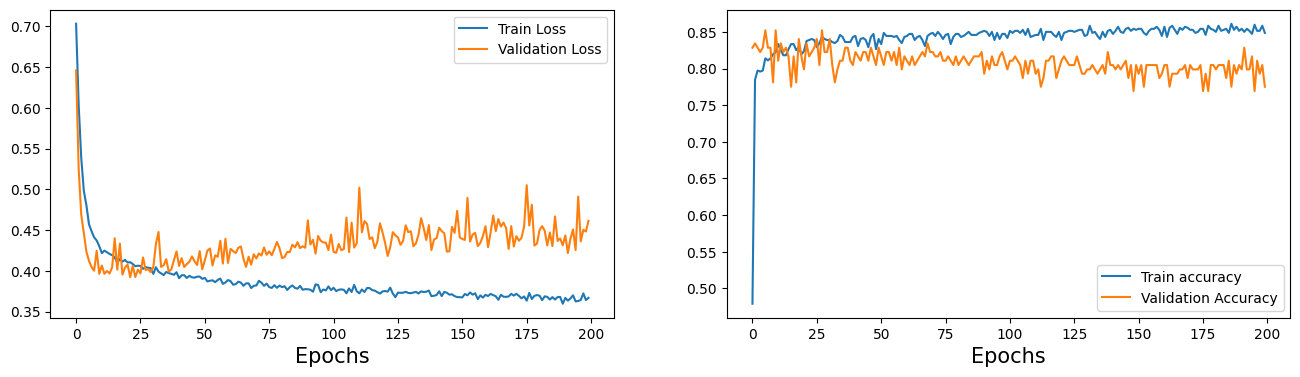

In [29]:
#plot the results of accuracy and loss
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(loss_hist_train)
plt.plot(loss_hist_valid)
plt.legend(['Train Loss','Validation Loss'])
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(accuracy_hist_train)
plt.plot(accuracy_hist_valid)
ax.set_xlabel('Epochs', size = 15)
plt.legend(['Train accuracy','Validation Accuracy'])
plt.show()

In [30]:
#we can also display the accuracy via sklearn
from sklearn.metrics import accuracy_score
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_nosurv).squeeze().round()
    y_pred_valid = model(X_valid_nosurv).squeeze().round()

    train_accuracy = accuracy_score(y_train, y_pred_train)
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)

    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Test Accuracy: {valid_accuracy:.4f}')

Train Accuracy: 0.8528
Test Accuracy: 0.7751


In [31]:
#it look like we are overfitting quite a bit. 200 Epochs seems to  be too much and should rather stop at around 25
#an important metric is the precision and recall score, which not takes the False Positive and False Negative into account
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_pred_train))
print(recall_score(y_train, y_pred_train))

0.9090909090909091
0.6716417910447762


In [32]:
#our model is has a low False Positive error, i.e., classifying people as dead but are actually true. On the other hand, it has a high False Negative error. Hence, a lot of people are predicted as alive but are actually dead.
#sumarize all of the results in the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred_train)

array([[434,  18],
       [ 88, 180]])